<a href="https://colab.research.google.com/github/sisifo3/P_T_2/blob/main/Net_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import argparse
import pandas as pd
import numpy as np
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch.optim as optim
import torch
import torch.nn as nn


In [ ]:

class NoisyImages():
    def __init__(self,transform=None):
        self.dataset = pd.read_csv('/content/drive/MyDrive/train_circle_v4/train_set_v2.csv', sep=' ')
        self.transform = transform

    def __getitem__(self, idx):
        image = np.load(self.dataset.iloc[idx, 0].split(',')[0])
        target = [self.dataset.iloc[idx, 0].split(',')[i] for i in range(1, 4)]
        
        if self.transform:
            image = np.expand_dims(np.asarray(image), axis=0)
            image = torch.from_numpy(np.array(image, dtype=np.float32))
            target = torch.from_numpy(np.array(np.asarray(target), dtype=np.float32))
            image = self.transform(image)

        return image, target

    def __len__(self):
        return len(self.dataset)


In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
device = get_device()

In [ ]:
import torch.nn as nn


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # input images 1 * 200 * 200
        self.L1 = nn.Sequential(nn.Conv2d(1, 32, 5), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2, 2))  # 32 * 98 * 98
        self.L2 = nn.Sequential(nn.Conv2d(32, 64, 3), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2))  # 64 * 48 * 48
        self.L3 = nn.Sequential(nn.Conv2d(64, 128, 3), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2, 2))  # 128 * 23 * 23
        self.L4 = nn.Sequential(nn.Conv2d(128, 128, 3), nn.BatchNorm2d(128), nn.ReLU())  # 128 * 21 * 21
        self.L5 = nn.Sequential(nn.Conv2d(128, 4, 1), nn.BatchNorm2d(4), nn.ReLU())  # 4 * 21 * 21
        self.FC = nn.Sequential(nn.Linear(4 * 21* 21, 256), nn.ReLU(), nn.Linear(256, 16), nn.ReLU())
        self.Last = nn.Linear(16, 3)

    def forward(self, x):
        x = self.L5(self.L4(self.L3(self.L2(self.L1(x)))))
        B, C, H, W = x.shape
        x = x.view(-1, C * H * W)
        x = self.FC(x)
        x = self.Last(x)
        return x

In [ ]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate"""
    lr = 0.001
    if 20 < epoch <= 30:
        lr = 0.0001
    elif 30 < epoch :
        lr = 0.00001
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    print("learning rate -> {}\n".format(lr))


In [ ]:
def main():

    model = Net()
    #model = nn.DataParallel(model)
    model.to(device)

    criterion1 = nn.MSELoss()
    criterion2 = nn.L1Loss()

    optimizer = optim.Adam(model.parameters(), lr =0.001)

    cudnn.benchmark = True
    normalize = transforms.Normalize(mean=[0.5], std=[0.5])

    trainset = NoisyImages(transforms.Compose([normalize,]))

    print(trainset)
    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size= 256, shuffle=True,
        num_workers=2)

    #output = open(args.out_file, "w")
    for epoch in range(1):
        print('Epoch {}'.format(epoch))

        #adjust_learning_rate(optimizer, epoch)
        model.train()
        running_loss = 0.0
        

        for i, (images, target) in enumerate(train_loader):

            images = images.to(device)
            target = target.to(device)

            output = model(images)

            loss = criterion1(output, target/200) + 0.1 * criterion2(output, target/200)

            # compute gradient and do optimizer step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            print('Loss: {:.4f}'.format(loss))
main()

Epoch 0
Loss: 0.3392
Loss: 0.1542
Loss: 0.2959
Loss: 0.0991
Loss: 0.1051
Loss: 0.1155
Loss: 0.0994
Loss: 0.0866
Loss: 0.0865
Loss: 0.0969
Loss: 0.0878
Loss: 0.0966
Loss: 0.0842
Loss: 0.0848
Loss: 0.0910
Loss: 0.0908
Loss: 0.0823
Loss: 0.0852
Loss: 0.0822
Loss: 0.0821
Loss: 0.0836
Loss: 0.0842
Loss: 0.0836
Loss: 0.0800
Loss: 0.0807
Loss: 0.0836
Loss: 0.0845
Loss: 0.0806
Loss: 0.0793
Loss: 0.0831
Loss: 0.0806
Loss: 0.0855
Loss: 0.0850
Loss: 0.0850
Loss: 0.0876
Loss: 0.0912
Loss: 0.0860
Loss: 0.0827
Loss: 0.0836
Loss: 0.0804


In [ ]:
import numpy as np
from shapely.geometry.point import Point
from skimage.draw import circle_perimeter_aa
import torch
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
#from network import Net


def draw_circle(img, row, col, rad):
    rr, cc, val = circle_perimeter_aa(row, col, rad)
    valid = (
        (rr >= 0) &
        (rr < img.shape[0]) &
        (cc >= 0) &
        (cc < img.shape[1])
    )
    img[rr[valid], cc[valid]] = val[valid]


def noisy_circle(size, radius, noise):
    img = np.zeros((size, size), dtype=np.float)

    # Circle
    row = np.random.randint(size)
    col = np.random.randint(size)
    rad = np.random.randint(10, max(10, radius))
    draw_circle(img, row, col, rad)

    # Noise
    img += noise * np.random.rand(*img.shape)
    return (row, col, rad), img


def find_circle(img):
    #model = Net()
    #checkpoint = torch.load('model.pth.tar')
    #model.load_state_dict(checkpoint)
    model.eval()

    with torch.no_grad():
        image = np.expand_dims(np.asarray(img), axis=0)
        image = torch.from_numpy(np.array(image, dtype=np.float32))
        normalize = transforms.Normalize(mean=[0.5], std=[0.5])
        image = normalize (image)
        image = image.unsqueeze(0)
        output = model(image)

    return [round(i) for i in (200*output).tolist()[0]]


def iou(params0, params1):
    row0, col0, rad0 = params0
    row1, col1, rad1 = params1

    shape0 = Point(row0, col0).buffer(rad0)
    shape1 = Point(row1, col1).buffer(rad1)

    return (
        shape0.intersection(shape1).area /
        shape0.union(shape1).area
    )


def main():
    results = []
    for _ in range(1000):
        params, img = noisy_circle(200, 75, 1)
        detected = find_circle(img)
        results.append(iou(params, detected))
    results = np.array(results)
    print((results > 0.7).mean())


if __name__ == '__main__':
    main()

0.0


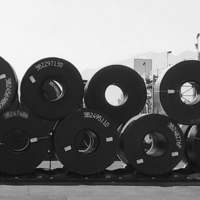

[27, -25, -68]


In [ ]:

def find_circle(img):
    model = Net()
    #checkpoint = torch.load('model.pth.tar')
    #model.load_state_dict(checkpoint)
    model.eval()

    with torch.no_grad():
        image = np.expand_dims(np.asarray(img), axis=0)
        image = torch.from_numpy(np.array(image, dtype=np.float32))
        normalize = transforms.Normalize(mean=[0.5], std=[0.5])
        image = normalize (image)
        image = image.unsqueeze(0)
        output = model(image)

    return [round(i) for i in (200*output).tolist()[0]]

import cv2
from google.colab.patches import cv2_imshow

data1 = '/content/drive/MyDrive/Screenshot from 2021-09-25 19-40-30_200200.png'
img = cv2.imread(data1, cv2.IMREAD_GRAYSCALE)
cv2_imshow(img)

detected = find_circle(img)
print(detected)

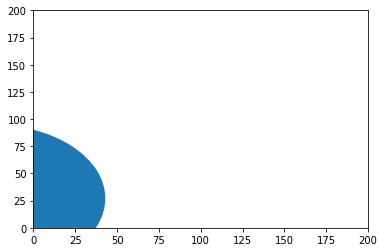

In [ ]:
import matplotlib.pyplot as plt

y = 27
x = -25
r = 68
plt.axis([0, 200, 0, 200])
c = plt.Circle((x,y), radius=r)
plt.gca().add_artist(c)
plt.show()